# Evaluate model on Binding Affinity test set

Code to compute evaluate models on test set. It generates the following files
for each evaluated model:
- test_results.tsv: File containing labels and predictions of the model
- test_metrics.tsv: File with global metrics:
    - Accuracy
    - Precision
    - Recall
    - Average prob of true negative labels (non-binders)
    - Average prob of true positive labels (binders)
    - AUROC

In [1]:
import os
import sys
import glob
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc, precision_score, recall_score, confusion_matrix

from nimbus.predictors import pHLABindingPredictor, pHLAPseudoseqBindingPredictor
from nimbus.data_processing import pHLADataset, pHLAPseudoseqDataset
from nimbus.utils import LoggerFactory

logger = LoggerFactory.get_logger('explore_pHLApredictor_nb', 'INFO')

In [2]:
DATA_DIR = '../data'
RAW_DATA = os.path.join(DATA_DIR, 'raw')
PROCESSED_DATA = os.path.join(DATA_DIR, 'processed')
HLA_FP_DIR = os.path.join(PROCESSED_DATA, 'hla_fingerprints')
hla_fp_36_data_file = os.path.join(HLA_FP_DIR, 'hla_index_netMHCpan_pseudoseq_res_representation.csv')
hla_fp_36_file = os.path.join(HLA_FP_DIR, 'hla_fingerprint_netMHCpan_pseudoseq_res_representation.npy')
hla_fp_400_data_file = os.path.join(HLA_FP_DIR, 'hla_af_patch_info_patch_r18_pt400.csv')
hla_fp_400_file = os.path.join(HLA_FP_DIR, 'hla_af_patch_emb_patch_r18_pt400.npy')
hla_pseudoseq_file = os.path.join(RAW_DATA, 'pHLA_binding', 'NetMHCpan_train', 'MHC_pseudo_fixed.dat')
test_netmhcpan_data_file = os.path.join(PROCESSED_DATA, 'pHLA_binding', 'NetMHCpan_dataset', 'test_set_peptides_data_MaxLenPep15_hla_ABC.csv.gz')

BASELINES_DIR = os.path.join('../checkpoints', 'baselines')
NETMHCPAN_BASELINE_DIR = os.path.join(BASELINES_DIR, 'netmhcpan41')
merged_netmhcpan_cd8_benchmark_file = os.path.join(
    NETMHCPAN_BASELINE_DIR, 'CD8_benchmark_filtered_outs.csv.gz'
)

CHECKPOINTS_DIR = '../checkpoints/csv_logger'
v_num = 0  # Version number
experiments_dict = {
    # 'pHLA_balance': {
    #     'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_balance', f'version_{v_num}', 'checkpoints','ep*'))[0],
    #     'hla_fp_size': 400,
    #     'hla_representation_type': 'surface_fp',
    # },
    # 'pHLA_balance_hla_pseudoseq': {
    #     'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_balance_hla_pseudoseq', f'version_{v_num}', 'checkpoints','ep*'))[0],
    #     'hla_fp_size': 36,
    #     'hla_representation_type': 'surface_fp',
    # },
    # 'pHLA_imbalance': {
    #     'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_imbalance', f'version_{v_num}', 'checkpoints','ep*'))[0],
    #     'hla_fp_size': 400,
    #     'hla_representation_type': 'surface_fp',
    # },
    'pHLA_imbalance_hla_pseudoseq': {
        'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_imbalance_hla_pseudoseq', f'version_{v_num}', 'checkpoints','ep*'))[0],
        'hla_fp_size': 36,
        'hla_representation_type': 'surface_fp',
    },
    # 'pHLA_balance_FILIP128': {
    #     'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_balance_FILIP128', f'version_{v_num}', 'checkpoints','ep*'))[0],
    #     'hla_fp_size': 400,
    #     'hla_representation_type': 'surface_fp',
    # },
    'pHLA_imbalance_hla_pseudoseq_ManSplits0123_4': {
        'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_imbalance_hla_pseudoseq_ManSplits0123_4', f'version_{v_num}', 'checkpoints','ep*'))[0],
        'hla_fp_size': 36,
        'hla_representation_type': 'surface_fp',
    },
    # 'pHLA_imbalance_hla_pseudoseq_ManSplits0124_3': {
    #     'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_imbalance_hla_pseudoseq_ManSplits0124_3', f'version_{v_num}', 'checkpoints','ep*'))[0],
    #     'hla_fp_size': 36,
    #     'hla_representation_type': 'surface_fp',
    # },
    # 'pHLA_imbalance_hla_pseudoseq_ManSplits0134_2': {
    #     'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_imbalance_hla_pseudoseq_ManSplits0134_2', f'version_{v_num}', 'checkpoints','ep*'))[0],
    #     'hla_fp_size': 36,
    #     'hla_representation_type': 'surface_fp',
    # },
    # 'pHLA_imbalance_hla_pseudoseq_ManSplits0234_1': {
    #     'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_imbalance_hla_pseudoseq_ManSplits0234_1', f'version_{v_num}', 'checkpoints','ep*'))[0],
    #     'hla_fp_size': 36,
    #     'hla_representation_type': 'surface_fp',
    # },
    # 'pHLA_imbalance_hla_pseudoseq_ManSplits1234_0': {
    #     'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_imbalance_hla_pseudoseq_ManSplits1234_0', f'version_{v_num}', 'checkpoints','ep*'))[0],
    #     'hla_fp_size': 36,
    #     'hla_representation_type': 'surface_fp',
    # },
    'pseudoseq_pHLA_imbalance_ManSplits0123_4': {
        'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pseudoseq_pHLA_imbalance_ManSplits0123_4', f'version_{v_num}', 'checkpoints','ep*'))[0],
        'hla_fp_size': 0,
        'hla_representation_type': 'pseudoseq',
    },
    'pHLA_imbalance_newHLAFP_ManSplits0123_4': {
        'model_checkpoint': glob.glob(os.path.join(CHECKPOINTS_DIR, 'pHLA_imbalance_newHLAFP_ManSplits0123_4', f'version_{v_num}', 'checkpoints','ep*'))[0],
        'hla_fp_size': 400,
        'hla_representation_type': 'surface_fp',
    },
}

In [3]:
# For debugging
test_netmhcpan_data = pd.read_csv(test_netmhcpan_data_file)
# pick 500 random samples
test_netmhcpan_data = test_netmhcpan_data.sample(500, replace=False, random_state=42)
# show num 1 labels
test_netmhcpan_data[test_netmhcpan_data['label'] == 1]

,peptide,is_mono_allelic,hla_allele,label
11222981,TLDYKPLSV,True,HLA-A02-01,1


In [4]:
# test_netmhcpan_data = pd.read_csv(test_netmhcpan_data_file)
hla_fp_36_emb = np.load(hla_fp_36_file)
hla_fp_400_emb = np.load(hla_fp_400_file)
hla_fp_36_data = pd.read_csv(hla_fp_36_data_file, index_col=1, names=['index'], header=0).to_dict()['index']
hla_fp_400_data = pd.read_csv(hla_fp_400_data_file, index_col=1, names=['index'], header=0).to_dict()['index']
hla_fp_36_dict = {hla: torch.Tensor(hla_fp_36_emb[idx]) for hla, idx in hla_fp_36_data.items()}
hla_fp_400_dict = {hla: torch.Tensor(hla_fp_400_emb[idx]) for hla, idx in hla_fp_400_data.items()}
hla_pseudoseq_dict = pd.read_csv(hla_pseudoseq_file, sep='\s+', names=['pseudoseq'], header=None).to_dict()['pseudoseq']


In [ ]:
test_dataset_pseudoseq_surf = pHLADataset(
    peptide_seq_arr=test_netmhcpan_data['peptide'].values,
    hla_names_arr=test_netmhcpan_data['hla_allele'].values, 
    hla_fp_dict=hla_fp_36_dict,
    labels=test_netmhcpan_data['label'].values
)

In [ ]:
test_dataset_patch_surf = pHLADataset(
    peptide_seq_arr=test_netmhcpan_data['peptide'].values,
    hla_names_arr=test_netmhcpan_data['hla_allele'].values, 
    hla_fp_dict=hla_fp_400_dict,
    labels=test_netmhcpan_data['label'].values
)

In [5]:
test_dataset_pseudoseq = pHLAPseudoseqDataset(
    peptide_seq_arr=test_netmhcpan_data['peptide'].values,
    hla_names_arr=test_netmhcpan_data['hla_allele'].values,
    hla_pseudoseq_dict=hla_pseudoseq_dict,
    labels=test_netmhcpan_data['label'].values
)

In [6]:
def load_pretrained_model(checkpoint_file, hla_representation_type='surface_fp'):
    if hla_representation_type == 'surface_fp':
        logger.info(f"Loading pHLABindingPredictor pretrained model {checkpoint_file}")
        model = pHLABindingPredictor.load_from_checkpoint(checkpoint_file)
    elif hla_representation_type == 'pseudoseq':
        logger.info(f"Loading pHLAPseudoseqBindingPredictor pretrained model {checkpoint_file}")
        model = pHLAPseudoseqBindingPredictor.load_from_checkpoint(checkpoint_file)
    else:
        logger.error(f"Unknown hla_representation_type {hla_representation_type}. "
                     f"Expected 'surface_fp' or 'pseudoseq'")
        sys.exit(1)
    return model


In [7]:
#for exp_name in experiments_dict.keys():
exp_name = 'pseudoseq_pHLA_imbalance_ManSplits0123_4'
hla_representation_type = experiments_dict[exp_name]['hla_representation_type']
model = load_pretrained_model(experiments_dict[exp_name]['model_checkpoint'], hla_representation_type=hla_representation_type)

if hla_representation_type == 'surface_fp':
    if 400 == experiments_dict[exp_name]['hla_fp_size']:
        logger.info(f"Using 400 dimensional HLA fingerprints")
        test_dataset = test_dataset_patch_surf
    elif 36 == experiments_dict[exp_name]['hla_fp_size']:
        logger.info(f"Using 36 dimensional HLA fingerprints")
        test_dataset = test_dataset_pseudoseq_surf
elif hla_representation_type == 'pseudoseq':
    logger.info(f"Using HLA pseudosequences")
    test_dataset = test_dataset_pseudoseq
else:
    logger.error(f"Unknown hla_representation_type {hla_representation_type} for {exp_name}")
    sys.exit(1)

model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
preds = []
labels = []
for i, batch in enumerate(test_loader):
    p, h, l = batch
    reps = model(p, h) # Filip Representation
    logits = model.linear_to_logits(reps)
    logits = model.to_pred(logits)
    pred = torch.sigmoid(logits).detach().cpu().numpy().tolist()
    preds.extend(pred)
    l = l.detach().cpu().numpy().tolist()
    labels.extend(l)
    
# save results to file in checkpoint folder
results = pd.DataFrame({'labels': labels, 'preds': preds})
results['labels'] = results['labels'].astype(int)
results_file = os.path.join(os.path.dirname(experiments_dict[exp_name]['model_checkpoint']), '..', 'test_results.tsv')
results.to_csv(results_file, index=False, sep='\t')
logger.info(f"Predicted test results saved to {results_file}")

metrics = {}
# compute accuracy
preds = np.array(preds)
labels = np.array(labels)
preds_05 = preds > 0.5
acc = np.mean(preds_05 == labels)
metrics['accuracy'] = acc
# compute precision: TP / (TP + FP)
precision = precision_score(labels, preds_05)
metrics['precision'] = precision
# compute recall: TP / (TP + FN)
recall = recall_score(labels, preds_05)
metrics['recall'] = recall
# compute auroc
fpr, tpr, _ = roc_curve(labels, preds)
auroc_score = auc(fpr, tpr)
metrics['auroc'] = auroc_score
# get pred value for negative class
neg_prob = np.mean(preds[labels == 0])
metrics['neg_prob'] = neg_prob
# get pred value for positive class
pos_prob = np.mean(preds[labels == 1])
metrics['pos_prob'] = pos_prob
# save metrics to file in checkpoint folder
metrics_file = os.path.join(os.path.dirname(experiments_dict[exp_name]['model_checkpoint']), '..', 'test_metrics.tsv')
pd.DataFrame(metrics, index=[0]).to_csv(metrics_file, index=False, sep='\t')
logger.info(f"Metrics saved to {metrics_file}")

3280680746 - INFO: Loading pHLAPseudoseqBindingPredictor pretrained model ../checkpoints/csv_logger/pseudoseq_pHLA_imbalance_ManSplits0123_4/version_0/checkpoints/epoch07-val_loss0.26-val_acc0.89.ckpt
3785421274 - INFO: Using HLA pseudosequences
3785421274 - INFO: Predicted test results saved to ../checkpoints/csv_logger/pseudoseq_pHLA_imbalance_ManSplits0123_4/version_0/checkpoints/../test_results.tsv
3785421274 - INFO: Metrics saved to ../checkpoints/csv_logger/pseudoseq_pHLA_imbalance_ManSplits0123_4/version_0/checkpoints/../test_metrics.tsv


# Analysis on precumputed results

In [3]:
# Load baselines data
cd8_netmhcpan_df = pd.read_csv(merged_netmhcpan_cd8_benchmark_file)

## ROC-AUC curve
Plot ROC-AUC curve for all the models

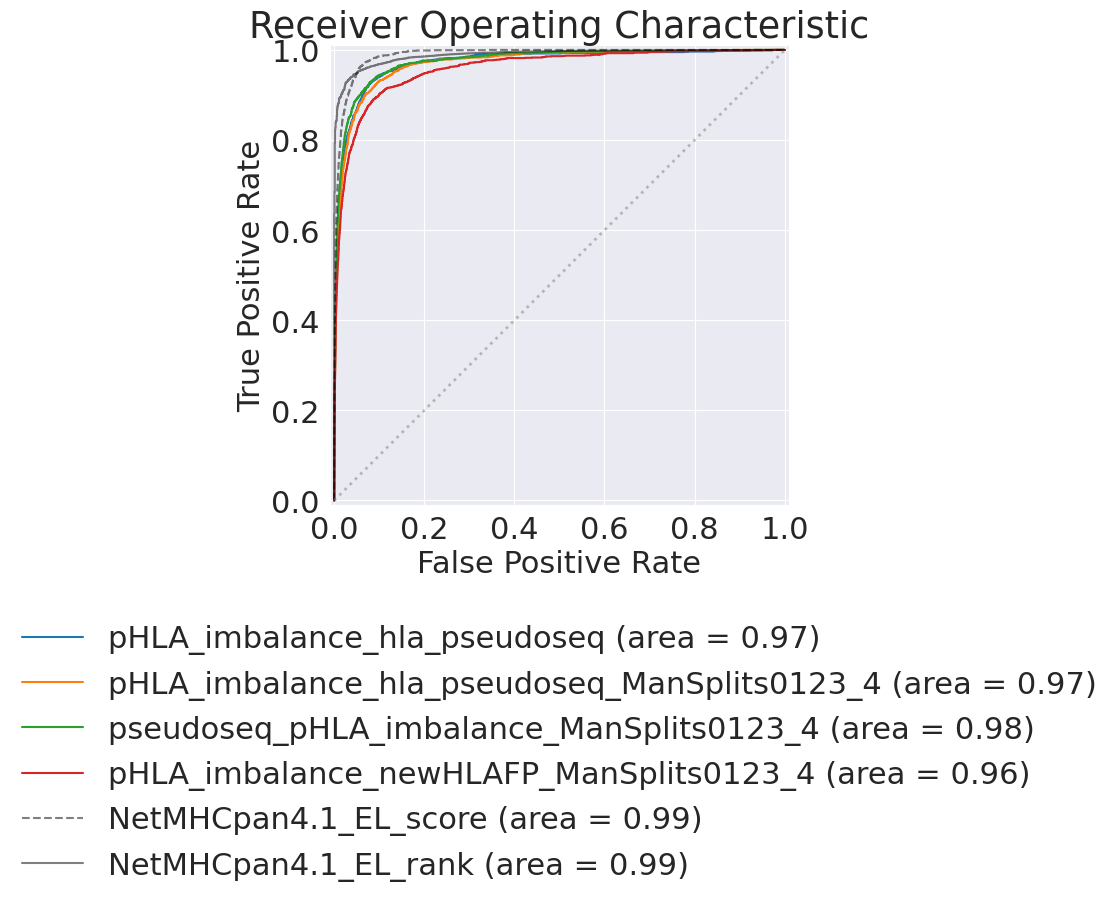

In [10]:
for exp_name in experiments_dict.keys():
    results_file = os.path.join(os.path.dirname(experiments_dict[exp_name]['model_checkpoint']), '..', 'test_results.tsv')
    try:
        results = pd.read_csv(results_file, sep='\t')
    except FileNotFoundError:
        logger.error(f"File {results_file} not found")
        continue
    fpr, tpr, _ = roc_curve(results['labels'], results['preds'])
    auroc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{exp_name} (area = {auroc_score:.2f})')
    
fpr, tpr, _ = roc_curve(cd8_netmhcpan_df['Exp'], cd8_netmhcpan_df['Score_EL'])
auroc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'NetMHCpan4.1_EL_score (area = {auroc_score:.2f})', linestyle='--', alpha=0.5, color='black')
# Notice that the tpr, fpr are swapped in the plot. This is because higher values of Rank_EL indicate lower binding affinity
tpr, fpr, _ = roc_curve(cd8_netmhcpan_df['Exp'], cd8_netmhcpan_df['%Rank_EL'])
auroc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'NetMHCpan4.1_EL_rank (area = {auroc_score:.2f})', linestyle='-', alpha=0.5, color='black')
    
plt.plot([0, 1], [0, 1], lw=2, linestyle='dotted', color='gray', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.ylim([-0.01, 1.01])
plt.xlim([-0.01, 1.01])
# plot legend outside the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), frameon=False, facecolor='white')
# make plot square
plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().set_size_inches(10, 10)
plt.rcParams.update({'font.size': 18})
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()


## Plot Precision-Recall curve

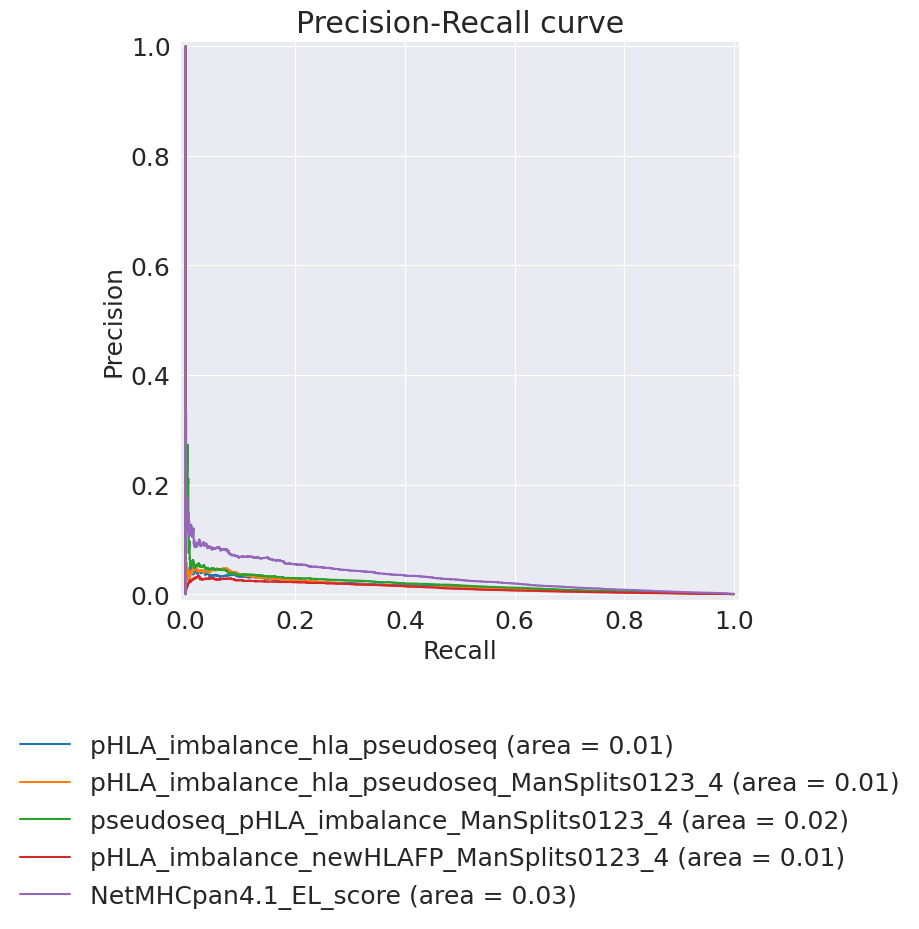

In [11]:
for exp_name in experiments_dict.keys():
    results_file = os.path.join(os.path.dirname(experiments_dict[exp_name]['model_checkpoint']), '..', 'test_results.tsv')
    try:
        results = pd.read_csv(results_file, sep='\t')
    except FileNotFoundError:
        logger.error(f"File {results_file} not found")
        continue
    precision, recall, _ = precision_recall_curve(results['labels'], results['preds'])
    # compute area under the curve
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{exp_name} (area = {pr_auc:.2f})')
    
precision, recall, _ = precision_recall_curve(cd8_netmhcpan_df['Exp'], cd8_netmhcpan_df['Score_EL'])
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'NetMHCpan4.1_EL_score (area = {pr_auc:.2f})')
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.ylim([-0.01, 1.01])
plt.xlim([-0.01, 1.01])
# plot legend outside the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), frameon=False, facecolor='white')
# make plot square
plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().set_size_inches(10, 10)
plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.savefig('pr_curve.png')
plt.show()

## Compare metrics across models

In [12]:
# compute metrics for baselines

metrics_baseline = {}
bl_preds_05 = cd8_netmhcpan_df['Score_EL'] > 0.5
fpr, tpr, _ = roc_curve(cd8_netmhcpan_df['Exp'], cd8_netmhcpan_df['Score_EL'])
metrics_baseline['NetMHCpan4.1_EL'] = {
    'accuracy': np.mean(bl_preds_05 == cd8_netmhcpan_df['Exp']),
    'precision': precision_score(cd8_netmhcpan_df['Exp'], bl_preds_05),
    'recall': recall_score(cd8_netmhcpan_df['Exp'], bl_preds_05),
    'auroc': auc(fpr, tpr),
    'neg_prob': np.mean(bl_preds_05[cd8_netmhcpan_df['Exp'] == 0]),
    'pos_prob': np.mean(bl_preds_05[cd8_netmhcpan_df['Exp'] == 1])
}
bl_preds_swb = cd8_netmhcpan_df['%Rank_EL'] < 2 
metrics_baseline['NetMHCpan4.1_EL_rank'] = {
    'accuracy': np.mean(bl_preds_swb == cd8_netmhcpan_df['Exp']),
    'precision': precision_score(cd8_netmhcpan_df['Exp'], bl_preds_swb),
    'recall': recall_score(cd8_netmhcpan_df['Exp'], bl_preds_swb),
    'auroc': auc(fpr, tpr),
    'neg_prob': np.mean(bl_preds_swb[cd8_netmhcpan_df['Exp'] == 0]),
    'pos_prob': np.mean(bl_preds_swb[cd8_netmhcpan_df['Exp'] == 1])
}

metrics_baseline_df = pd.DataFrame.from_dict(metrics_baseline, orient='columns').T
metrics_baseline_df

,accuracy,precision,recall,auroc,neg_prob,pos_prob
NetMHCpan4.1_EL,0.997311,0.026210,0.499684,0.988986,0.002619,0.499684
NetMHCpan4.1_EL_rank,0.985427,0.007712,0.801392,0.988986,0.014547,0.801392


In [13]:
metrics = {}
for exp_name in experiments_dict.keys():
    metrics_file = os.path.join(os.path.dirname(experiments_dict[exp_name]['model_checkpoint']), '..', 'test_metrics.tsv')
    try:
        metrics[exp_name] = pd.read_csv(metrics_file, sep='\t')
    except FileNotFoundError:
        logger.error(f"File {metrics_file} not found")
        continue
# Add baseline to metrics
for i, r in metrics_baseline_df.iterrows():
    metrics[i] = pd.DataFrame(r).T
    
# Make metrics df keeping exp_name in column
metrics_df = pd.concat(metrics).reset_index(drop=False)
metrics_df = metrics_df.rename(columns={'level_0': 'exp_name'})
metrics_df = metrics_df.drop(columns='level_1')
metrics_df

,exp_name,accuracy,precision,recall,auroc,neg_prob,pos_prob
0,pHLA_imbalance_hla_pseudoseq,0.979942,0.005279,0.753614,0.972073,0.036209,0.699198
1,pHLA_imbalance_hla_pseudoseq_ManSplits0123_4,0.978736,0.004918,0.743976,0.970676,0.040048,0.684277
2,pseudoseq_pHLA_imbalance_ManSplits0123_4,0.983348,0.006329,0.750602,0.975022,0.038879,0.686499
3,pHLA_imbalance_newHLAFP_ManSplits0123_4,0.979648,0.004746,0.686747,0.958896,0.038990,0.652908
4,NetMHCpan4.1_EL,0.997311,0.026210,0.499684,0.988986,0.002619,0.499684
5,NetMHCpan4.1_EL_rank,0.985427,0.007712,0.801392,0.988986,0.014547,0.801392


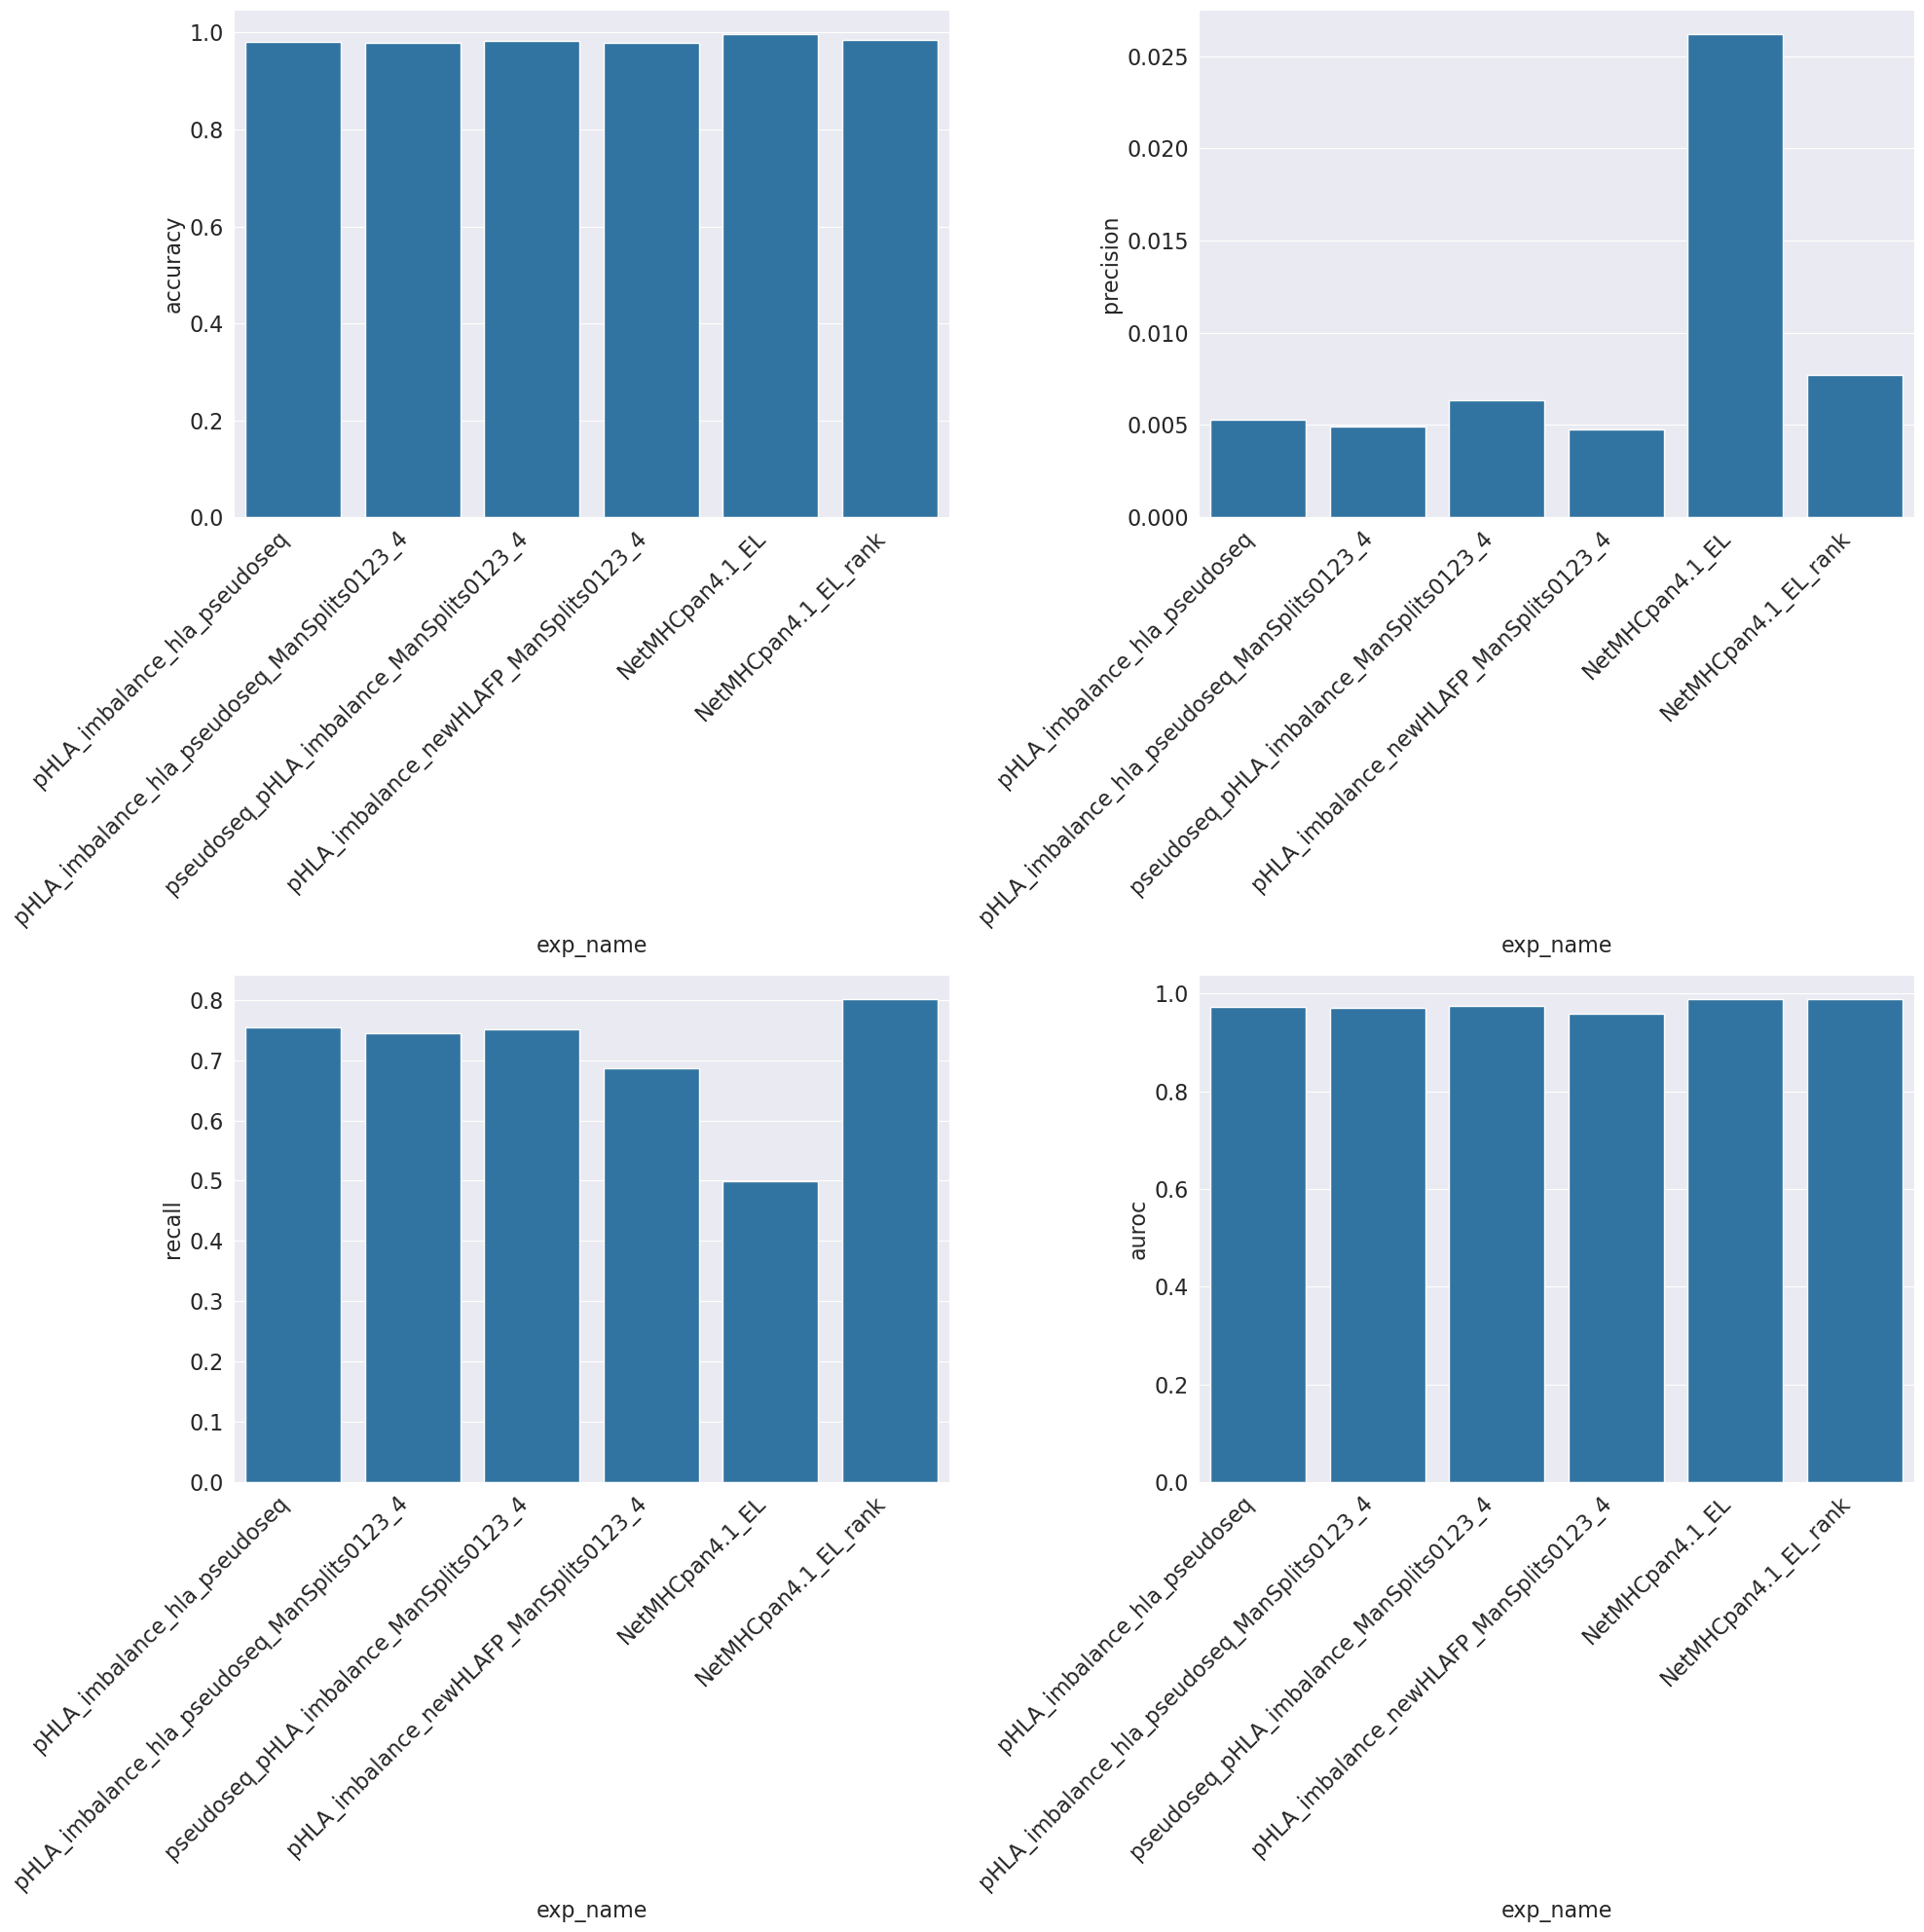

In [14]:
# Plot metrics
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
sns.barplot(x='exp_name', y='accuracy', data=metrics_df, ax=axs[0, 0])
sns.barplot(x='exp_name', y='precision', data=metrics_df, ax=axs[0, 1])
sns.barplot(x='exp_name', y='recall', data=metrics_df, ax=axs[1, 0])
sns.barplot(x='exp_name', y='auroc', data=metrics_df, ax=axs[1, 1])
plt.rcParams.update({'font.size': 12})
# rotate x labels
for ax in axs.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
plt.tight_layout()
plt.show()

## Confusion matrix
Make a plot with all confusion matrices. The confusion matrix is computed with a threshold of 0.5. The title is the experiment name.

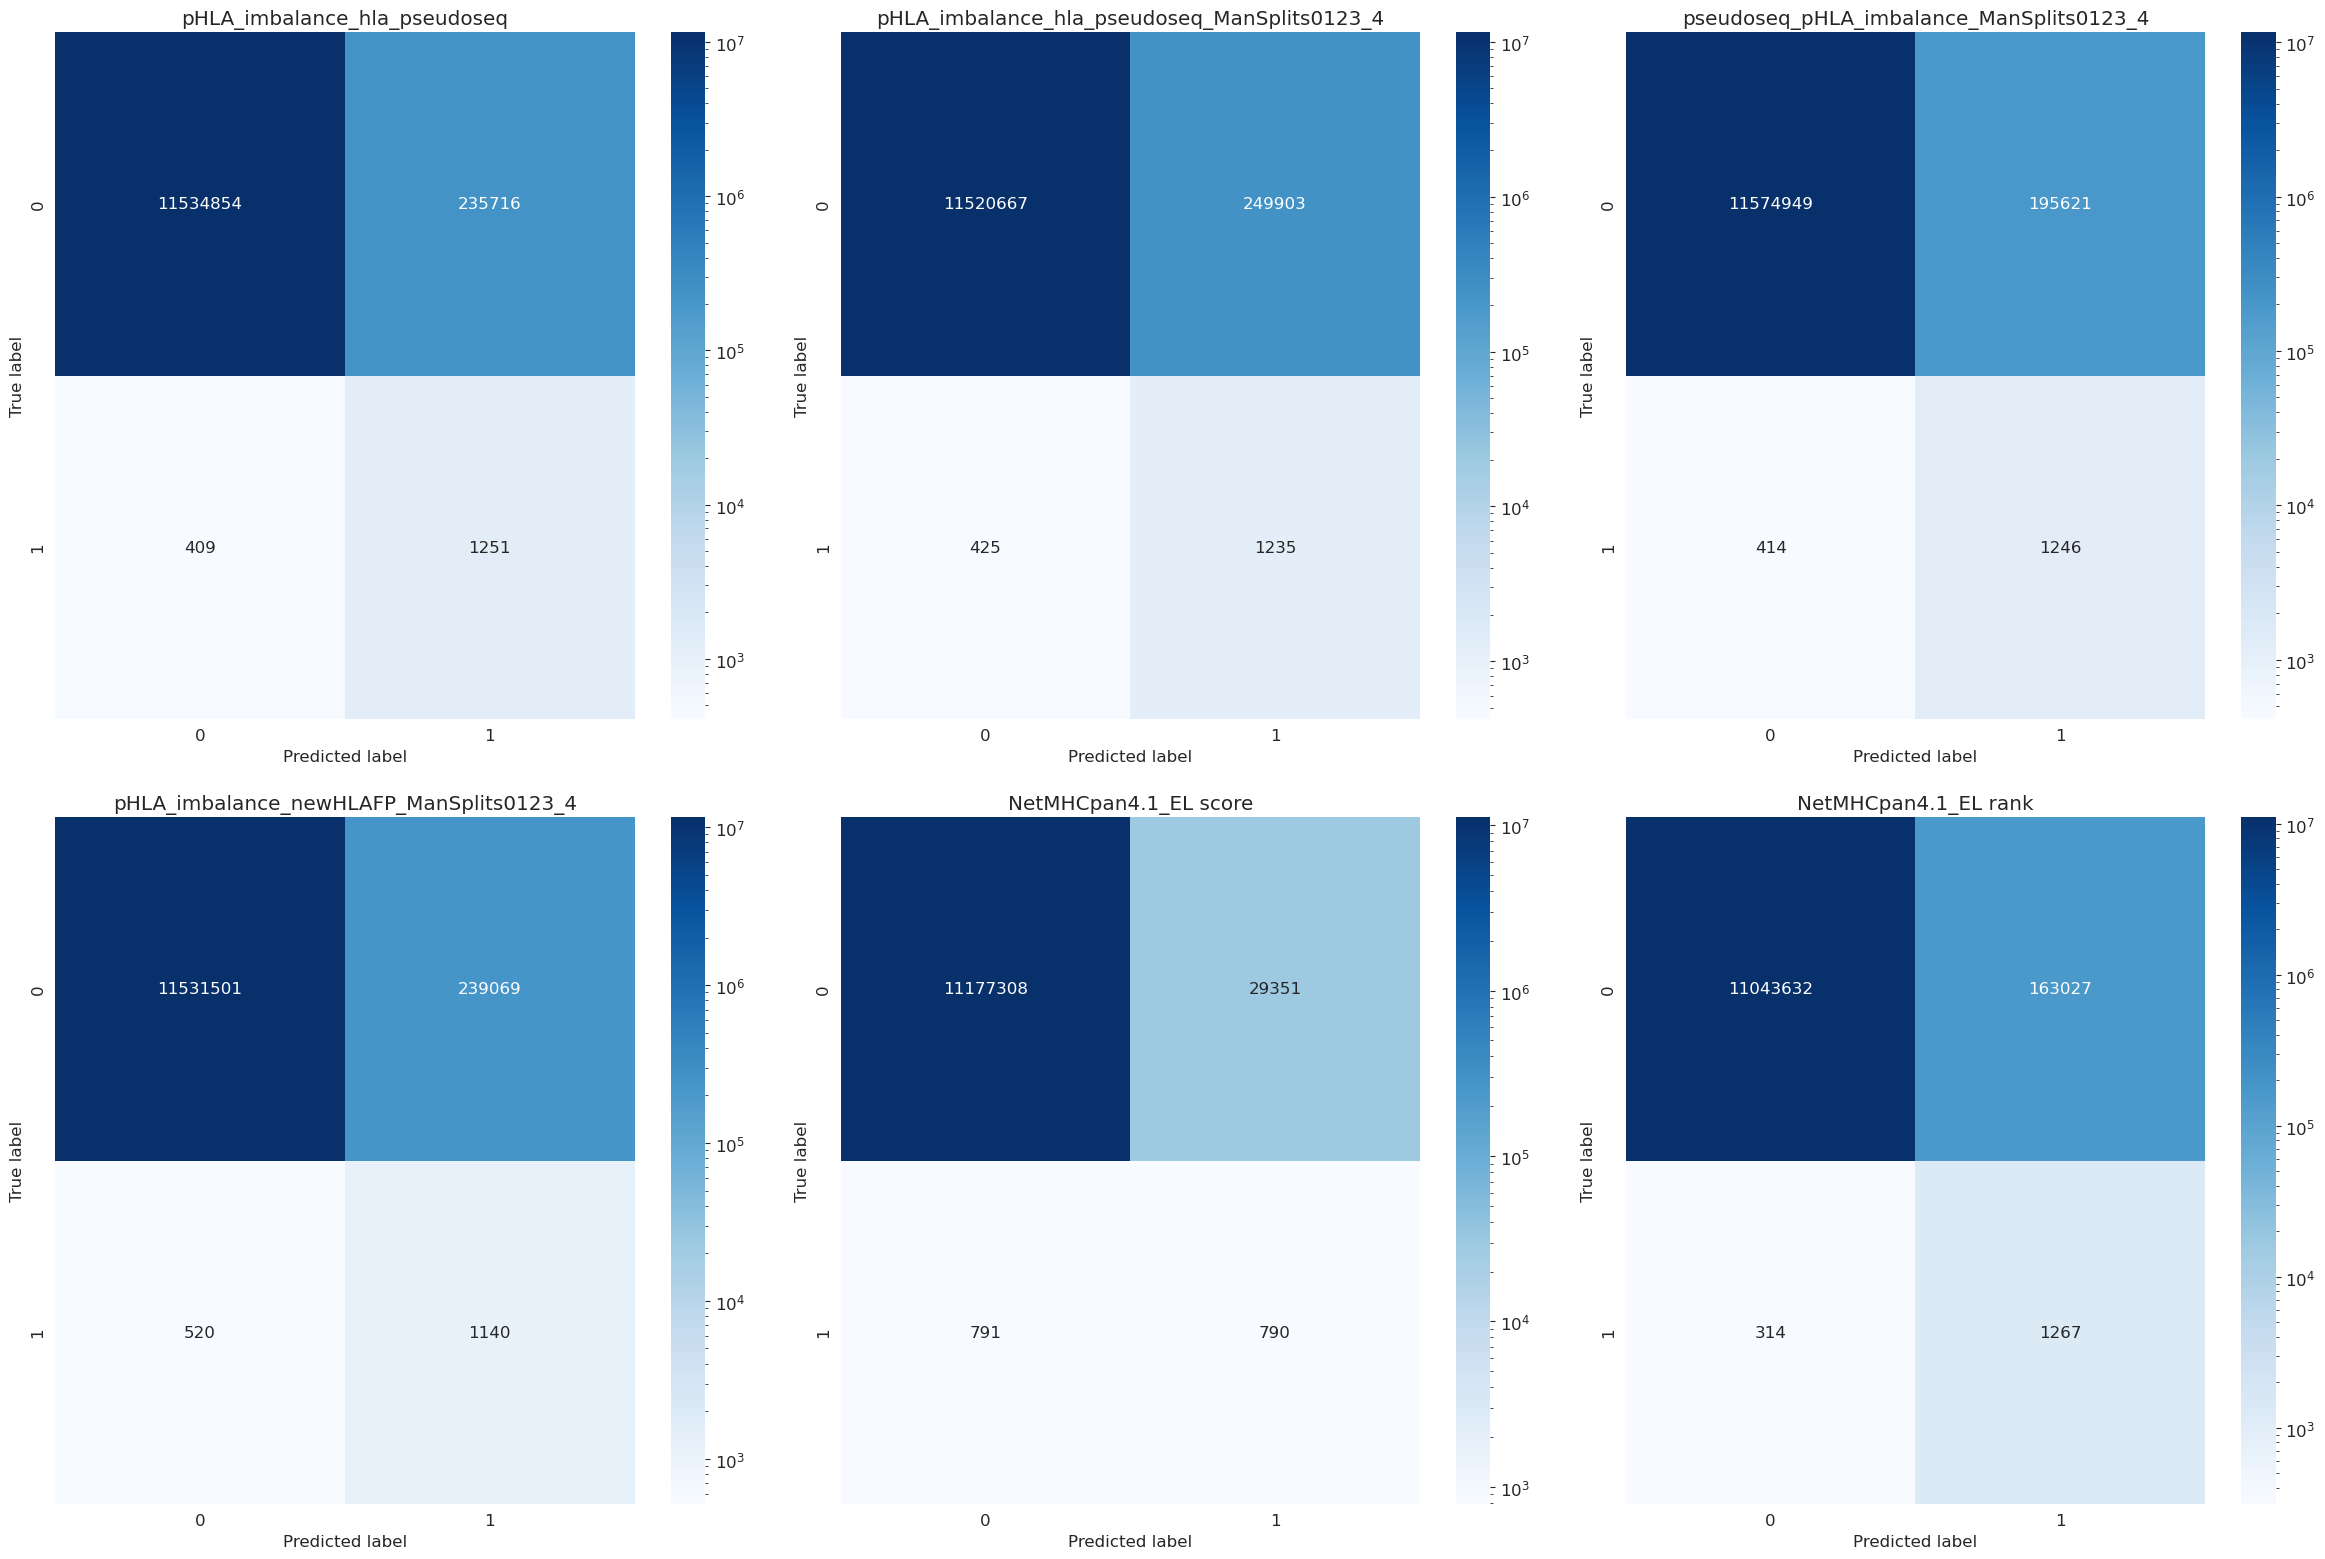

In [24]:
from matplotlib.colors import LogNorm

n_baselines = 2
n_plots = len(experiments_dict.keys()) + n_baselines
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 8*n_rows))

for i, exp_name in enumerate(experiments_dict.keys()):
    results_file = os.path.join(os.path.dirname(experiments_dict[exp_name]['model_checkpoint']), '..', 'test_results.tsv')
    try:
        results = pd.read_csv(results_file, sep='\t')
    except FileNotFoundError:
        logger.error(f"File {results_file} not found")
        continue
    conf_matrix = confusion_matrix(results['labels'], results['preds'] > 0.5)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[i//n_cols, i%n_cols], norm=LogNorm())
    axs[i//n_cols, i%n_cols].set_title(exp_name)
    axs[i//n_cols, i%n_cols].set_xlabel('Predicted label')
    axs[i//n_cols, i%n_cols].set_ylabel('True label')
    
# Plot baselines
conf_matrix = confusion_matrix(cd8_netmhcpan_df['Exp'], cd8_netmhcpan_df['Score_EL'] > 0.5)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[(i+1)//n_cols, (i+1)%n_cols], norm=LogNorm())
axs[(i+1)//n_cols, (i+1)%n_cols].set_title('NetMHCpan4.1_EL score')
axs[(i+1)//n_cols, (i+1)%n_cols].set_xlabel('Predicted label')
axs[(i+1)//n_cols, (i+1)%n_cols].set_ylabel('True label')

conf_matrix = confusion_matrix(cd8_netmhcpan_df['Exp'], cd8_netmhcpan_df['%Rank_EL'] < 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[(i+2)//n_cols, (i+2)%n_cols], norm=LogNorm())
axs[(i+2)//n_cols, (i+2)%n_cols].set_title('NetMHCpan4.1_EL rank')
axs[(i+2)//n_cols, (i+2)%n_cols].set_xlabel('Predicted label')
axs[(i+2)//n_cols, (i+2)%n_cols].set_ylabel('True label')

plt.rcParams.update({'font.size': 20})
plt.tight_layout()
plt.show()

## Check false positives and false negatives

Get information about which hla alleles are more likely to be false positives and false negatives for each model when using the threshold of 0.5.

In [12]:
test_netmhcpan_data = pd.read_csv(test_netmhcpan_data_file)

In [13]:
training_ba_data_file = os.path.join(PROCESSED_DATA, 'pHLA_binding', 'NetMHCpan_dataset', 'train_binding_affinity_peptides_data_MaxLenPep15_hla_ABC_with_BalancedSplits.csv')
training_ba_data = pd.read_csv(training_ba_data_file)
# count num of positive and negative labels for each hla allele
training_ba_data['label'] = training_ba_data['label'].astype(int)
hla_allele_counts = training_ba_data.groupby('hla_allele')['label'].value_counts().unstack().fillna(0)
hla_allele_counts['train_total'] = hla_allele_counts.sum(axis=1)
hla_allele_counts = hla_allele_counts.sort_values(by='train_total', ascending=False)
hla_allele_counts = hla_allele_counts.astype(int)
hla_allele_counts = hla_allele_counts.rename(columns={0: 'train_NB', 1: 'train_B'})
# compute ratio of positive labels
hla_allele_counts['train_ratio_pos_per_total'] = hla_allele_counts['train_B'] / hla_allele_counts['train_total']
hla_allele_counts

label,train_NB,train_B,train_total,train_ratio_pos_per_total
hla_allele,,,,
HLA-A02-01,8139,4814,12953,0.371651
HLA-A03-01,5401,2180,7581,0.287561
HLA-A11-01,4352,2226,6578,0.338401
HLA-A02-03,3999,2424,6423,0.377394
HLA-A31-01,4190,1616,5806,0.278333
...,...,...,...,...
HLA-B15-10,104,0,104,0.000000
HLA-C08-03,103,0,103,0.000000
HLA-B27-10,102,0,102,0.000000


In [ ]:
for exp_name in experiments_dict.keys():
    results_file = os.path.join(os.path.dirname(experiments_dict[exp_name]['model_checkpoint']), '..', 'test_results.tsv')
    try:
        results = pd.read_csv(results_file, sep='\t')
    except FileNotFoundError:
        logger.error(f"File {results_file} not found")
        continue
    results['preds_05'] = results['preds'] > 0.5
    false_positives = results[(results['labels'] == 0) & (results['preds_05'] == 1)]
    fp_index = false_positives.index
    fp_data = test_netmhcpan_data.iloc[fp_index]
    fp_hla_alleles = fp_data['hla_allele'].value_counts()
    # add columns with training counts per allele
    fp_hla_alleles = pd.concat([fp_hla_alleles, hla_allele_counts], axis=1, join='inner')#.sort_values(by='total', ascending=False)
    false_negatives = results[(results['labels'] == 1) & (results['preds_05'] == 0)]
    fn_index = false_negatives.index
    fn_data = test_netmhcpan_data.iloc[fn_index]
    fn_hla_alleles = fn_data['hla_allele'].value_counts()
    # add columns with training counts per allele
    fn_hla_alleles = pd.concat([fn_hla_alleles, hla_allele_counts], axis=1, join='inner')#.sort_values(by='total', ascending=False)
    
    logger.info(f"False positives (non-binders classified as binders) for {exp_name} were {len(fp_data)}:")
    logger.info(fp_hla_alleles)
    logger.info(f"False negatives (binders classified as non-binders) for {exp_name} were {len(fn_data)}:")
    logger.info(fn_hla_alleles)
    break

In [11]:
from sklearn.metrics import classification_report
print(classification_report(results['labels'], results['preds']>0.5))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98  11770570
           1       0.00      0.70      0.00      1660

    accuracy                           0.96  11772230
   macro avg       0.50      0.83      0.49  11772230
weighted avg       1.00      0.96      0.98  11772230

